In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Twitter_Data.csv
/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Reddit_Data.csv


# Load the Packages

In [5]:
# upgrade sklearn

!pip install scikit-learn --upgrade

In [6]:
!pip install mlflow

In [7]:
!pip install dagshub

In [61]:
import numpy as np
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import mlflow
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import json
import joblib
import os
import yaml
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

In [10]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /usr/share/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /usr/share/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron

True

In [11]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
from nltk.stem import WordNetLemmatizer, PorterStemmer

In [13]:
import sklearn

sklearn.__version__

'1.5.2'

# Load the Data

In [14]:
# load the data

DATA_PATH = "/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Reddit_Data.csv"

df = pd.read_csv(DATA_PATH)

df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [15]:
# shape of the data

df.shape

(37249, 2)

**The dataset has around `37 thousand` rows.**

In [16]:
# rename columns

df.rename({"clean_comment":"comment",
           "category":"sentiment"},axis=1,inplace=True)

In [17]:
# check for missing values

(
    df.isna().sum()
)

comment      100
sentiment      0
dtype: int64

In [18]:
# print the rows having missing values

(
    df.loc[
        df['comment'].isna()
    ]
)

,comment,sentiment
413,NaN,0
605,NaN,0
2422,NaN,0
2877,NaN,0
3307,NaN,0
...,...,...
35975,NaN,0
36036,NaN,0
37043,NaN,0
37111,NaN,0


In [19]:
# sentiment of rows that have missing values


(
    df.loc[
        df['comment'].isna(),"sentiment"
    ]
    .value_counts()
)

sentiment
0    100
Name: count, dtype: int64

**All the missing rows have sentiment of 0**

Action:
**Remove the rows having missing values**

In [20]:
# remove missing values

print("Rows in data before removing missing values ",df.shape[0])

df = df.dropna()

print("Rows in data after removing missing values ",df.shape[0])

Rows in data before removing missing values  37249
Rows in data after removing missing values  37149


In [21]:
# check for duplicate comments

df['comment'].duplicated().sum()

350

**Some of the comments are duplicated and have to be removed**

In [22]:
# remove duplicate rows

print("Rows in data before removing duplicate rows ",df.shape[0])

df = df.drop_duplicates(subset=['comment'])

print("Rows in data after removing duplicate rows ",df.shape[0])

Rows in data before removing duplicate rows  37149
Rows in data after removing duplicate rows  36799


<Axes: xlabel='sentiment'>

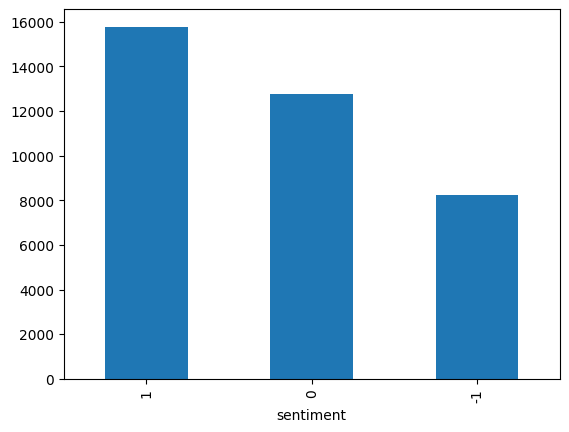

In [23]:
# traget distribution

(
    df['sentiment']
    .value_counts()
    .plot(kind='bar')
)

# Preprocessing of Text

In [24]:
# remove whitespaces

df['comment'] = df['comment'].str.lstrip()

In [25]:
# count the number of words

def count_words(text):
    return len(text.split(" "))

In [26]:
df['word_count'] = df['comment'].apply(count_words)

In [27]:
# statistics on word_count

df['word_count'].agg(['min','max','mean'])

min        1.000000
max     1308.000000
mean      30.470339
Name: word_count, dtype: float64

In [28]:
# convert all the sentences to lowercase

df['comment'] = df['comment'].str.lower()

In [29]:
def removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    return text

def removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [30]:
df['comment'].head()

0    family mormon have never tried explain them th...
1    buddhism has very much lot compatible with chr...
2    seriously don say thing first all they won get...
3    what you have learned yours and only yours wha...
4    for your own benefit you may want read living ...
Name: comment, dtype: object

In [31]:
# remove numbers and puctuations

def preprocess_text(text):
    text = removing_numbers(text)
    text = removing_urls(text)
    text = removing_punctuations(text)
    
    return text

df['comment'] = df['comment'].apply(preprocess_text)

In [32]:
# remove stopwords from comments

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    return " ".join(filtered_sentence)

df['comment'] = df['comment'].apply(remove_stopwords)

In [33]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [34]:
# lemmatize the text 

# lemmatizer to be used instead. not working in kaggle.

def stemming(text):
    stemmer = PorterStemmer()
    text = [stemmer.stem(word) for word in text.split(" ")]
    return " ".join(text)

df['comment'] = df['comment'].apply(stemming)

# Model Building and Feature Eng pipeline

In [35]:
# make X and y

X = df.drop(columns='sentiment')
y = df['sentiment']

X

,comment,word_count
0,famili mormon never tri explain still stare pu...,40
1,buddhism much lot compat christian especi cons...,197
2,serious say thing first get complex explain no...,87
3,learn want teach differ focu goal wrap paper b...,30
4,benefit may want read live buddha live christ ...,113
...,...,...
37244,jesu,1
37245,kya bhai pure saal chutiya banaya modi aur jab...,19
37246,downvot karna tha par upvot hogaya,7
37247,haha nice,3


In [36]:
# train test split the data

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=True,stratify=y)

print("The shape of X_train is",X_train.shape)
print("The shape of X_test is",X_test.shape)

The shape of X_train is (29439, 2)
The shape of X_test is (7360, 2)


Text(0.5, 1.0, 'Test Data')

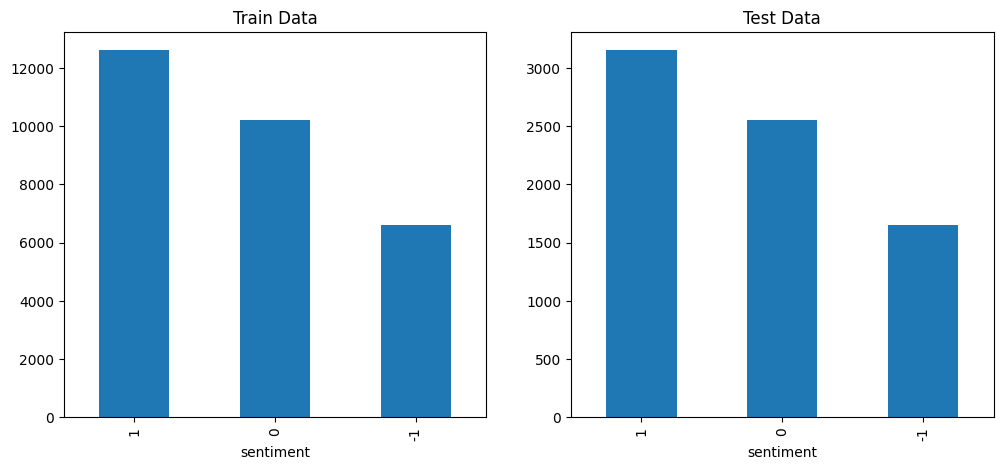

In [37]:
# plot the two graphs

fig = plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
y_train.value_counts().plot(kind='bar')
plt.title("Train Data")

plt.subplot(1,2,2)
y_test.value_counts().plot(kind='bar')
plt.title("Test Data")

In [38]:
sklearn.set_config(transform_output='default')

In [39]:
# transform the output variable
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [40]:
# form the preprocessor

preprocessor = ColumnTransformer(transformers=[
    ('encode',CountVectorizer(decode_error='ignore'),'comment'),
    ('scale',StandardScaler(),['word_count'])
],n_jobs=-1)

preprocessor

ColumnTransformer(n_jobs=-1,
                  transformers=[('encode',
                                 CountVectorizer(decode_error='ignore'),
                                 'comment'),
                                ('scale', StandardScaler(), ['word_count'])])

In [41]:
preprocessor.fit_transform(X_train.sample(20)).toarray()

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.43568977],
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
         0.        ,  4.02601304],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.10630232],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.13624663],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.        ,  0.94174868],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.43269534]])

In [42]:
# form the model building pipeline

model_pipe = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('clf',None)
])


In [46]:
# list of preprocessors

preprocessors = [CountVectorizer(decode_error='ignore'),TfidfVectorizer(decode_error='ignore')]

# list of classifiers
classifiers = [LogisticRegression(max_iter=1000),
               SVC(),
               RandomForestClassifier(),
               GradientBoostingClassifier(),
               XGBClassifier(objective="multi:softmax",num_class=3),
               LGBMClassifier()]

In [47]:
# params grid

params_grid = {
    "preprocessor__encode": preprocessors,
    "clf": classifiers
}

search = GridSearchCV(model_pipe,params_grid,
                      scoring='accuracy',n_jobs=-1,
                     cv=3,verbose=3)

search

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('encode',
                                                                         CountVectorizer(decode_error='ignore'),
                                                                         'comment'),
                                                                        ('scale',
                                                                         StandardScaler(),
                                                                         ['word_count'])])),
                                       ('clf', None)]),
             n_jobs=-1,
             param_grid={'clf': [LogisticRegression(max_iter=1000), SVC(),
                                 RandomForestClassifier(),
                                 GradientBoostingClassifier(),
                                 XGBCl...
                                               max_delta_step=None,
                                               max_depth=None, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=None, n_jobs=None,
                                               num_class=3,
                                               num_parallel_tree=None, ...),
                                 LGBMClassifier()],
                         'preprocessor__encode': [CountVectorizer(decode_error='ignore'),
                                                  TfidfVectorizer(decode_error='ignore')]},
             scoring='accuracy', verbose=3)

In [48]:
# fit the grid search

search.fit(X_train,y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END clf=LogisticRegression(max_iter=1000), preprocessor__encode=CountVectorizer(decode_error='ignore');, score=0.817 total time=   4.1s
[CV 3/3] END clf=LogisticRegression(max_iter=1000), preprocessor__encode=TfidfVectorizer(decode_error='ignore');, score=0.804 total time=   4.0s
[CV 3/3] END clf=SVC(), preprocessor__encode=CountVectorizer(decode_error='ignore');, score=0.773 total time= 2.7min
[CV 1/3] END clf=RandomForestClassifier(), preprocessor__encode=CountVectorizer(decode_error='ignore');, score=0.773 total time= 1.9min
[CV 3/3] END clf=RandomForestClassifier(), preprocessor__encode=CountVectorizer(decode_error='ignore');, score=0.779 total time= 2.0min
[CV 1/3] END clf=GradientBoostingClassifier(), preprocessor__encode=CountVectorizer(decode_error='ignore');, score=0.717 total time=  55.5s
[CV 3/3] END clf=GradientBoostingClassifier(), preprocessor__encode=CountVectorizer(decode_error='ignore');, score=0.722

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('encode',
                                                                         CountVectorizer(decode_error='ignore'),
                                                                         'comment'),
                                                                        ('scale',
                                                                         StandardScaler(),
                                                                         ['word_count'])])),
                                       ('clf', None)]),
             n_jobs=-1,
             param_grid={'clf': [LogisticRegression(max_iter=1000), SVC(),
                                 RandomForestClassifier(),
                                 GradientBoostingClassifier(),
                                 XGBCl...
                                               max_delta_step=None,
                                               max_depth=None, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=None, n_jobs=None,
                                               num_class=3,
                                               num_parallel_tree=None, ...),
                                 LGBMClassifier()],
                         'preprocessor__encode': [CountVectorizer(decode_error='ignore'),
                                                  TfidfVectorizer(decode_error='ignore')]},
             scoring='accuracy', verbose=3)

In [49]:
# best score
search.best_score_

0.8302252114541934

In [50]:
# best preprocessor-model combo
search.best_params_

{'clf': LGBMClassifier(),
 'preprocessor__encode': CountVectorizer(decode_error='ignore')}

In [51]:
# cv results

pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_preprocessor__encode,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,3.777963,0.106370,0.386104,0.018313,LogisticRegression(max_iter=1000),CountVectorizer(decode_error='ignore'),"{'clf': LogisticRegression(max_iter=1000), 'pr...",0.817283,0.820137,0.823194,0.820204,0.002413,3
1,4.053034,0.340216,0.390309,0.022593,LogisticRegression(max_iter=1000),TfidfVectorizer(decode_error='ignore'),"{'clf': LogisticRegression(max_iter=1000), 'pr...",0.804035,0.802711,0.803730,0.803492,0.000566,4
2,120.958441,1.489209,41.199640,0.327042,SVC(),CountVectorizer(decode_error='ignore'),"{'clf': SVC(), 'preprocessor__encode': CountVe...",0.769591,0.764088,0.772852,0.768844,0.003617,9
3,162.856656,0.659540,42.062361,0.707384,SVC(),TfidfVectorizer(decode_error='ignore'),"{'clf': SVC(), 'preprocessor__encode': TfidfVe...",0.792011,0.797921,0.794660,0.794864,0.002417,7
4,119.705880,4.319876,2.098350,0.093652,RandomForestClassifier(),CountVectorizer(decode_error='ignore'),"{'clf': RandomForestClassifier(), 'preprocesso...",0.773056,0.782330,0.778763,0.778050,0.003819,8
5,114.249723,2.324874,2.143536,0.056154,RandomForestClassifier(),TfidfVectorizer(decode_error='ignore'),"{'clf': RandomForestClassifier(), 'preprocesso...",0.763681,0.769591,0.770407,0.767893,0.002997,10
6,52.095641,2.107489,0.450987,0.012663,GradientBoostingClassifier(),CountVectorizer(decode_error='ignore'),"{'clf': GradientBoostingClassifier(), 'preproc...",0.717314,0.717110,0.721900,0.718774,0.002211,12
7,95.079270,1.081714,0.464272,0.005934,GradientBoostingClassifier(),TfidfVectorizer(decode_error='ignore'),"{'clf': GradientBoostingClassifier(), 'preproc...",0.717416,0.718129,0.725976,0.720507,0.003878,11
8,33.086478,0.269877,0.626684,0.008529,"XGBClassifier(base_score=None, booster=None, c...",CountVectorizer(decode_error='ignore'),"{'clf': XGBClassifier(base_score=None, booster...",0.798533,0.798329,0.803424,0.800095,0.002355,5
9,92.162306,1.971084,0.856074,0.118770,"XGBClassifier(base_score=None, booster=None, c...",TfidfVectorizer(decode_error='ignore'),"{'clf': XGBClassifier(base_score=None, booster...",0.795170,0.797106,0.800163,0.797480,0.002056,6


In [69]:
results = dict(search.cv_results_)

In [53]:
# save the results df into a csv file

pd.DataFrame(results).to_csv("/kaggle/working/results.csv",index=False)

In [54]:
# pickle the results object and save

import pickle as pkl

with open("/kaggle/working/results.pkl",'wb') as res:
    pkl.dump(results,res)

In [55]:
# best model

best_model = search.best_estimator_

In [56]:
# save the best model in output
output_dir = '/kaggle/working/models'
os.makedirs(output_dir,exist_ok=True)

joblib.dump(best_model,os.path.join(output_dir,"best_model.joblib"))

['/kaggle/working/models/best_model.joblib']

In [57]:
# get the train and test predictions

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

In [58]:
from sklearn.metrics import accuracy_score, f1_score

In [60]:
# get the accuracy score

print("The train accuracy score is: ",accuracy_score(y_train,y_pred_train))
print("The train f1 score is: ",f1_score(y_train,y_pred_train,average='macro'))

print("#"*50)

print("The test accuracy score is: ",accuracy_score(y_test,y_pred_test))
print("The test f1 score is: ",f1_score(y_test,y_pred_test,average='macro'))

The train accuracy score is:  0.8630727945922076
The train f1 score is:  0.8503315364834981
##################################################
The test accuracy score is:  0.8302989130434782
The test f1 score is:  0.8129408478652994


In [63]:
# perform cross validation

score = cross_val_score(best_model,X_train,y_train,
                        cv=5,scoring='accuracy',
                        n_jobs=-1,verbose=2)
score

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.590896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10971
[LightGBM] [Info] Number of data points in the train set: 23551, number of used features: 2790
[LightGBM] [Info] Start training from score -1.495242
[LightGBM] [Info] Start training from score -1.057721
[LightGBM] [Info] Start training from score -0.847326
[CV] END .................................................... total time=   7.6s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.617385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11054
[LightGBM] [Info] Number of data points in the train set: 23551, number of used features: 2814
[LightGBM] [Info] Start training from score -

array([0.83712636, 0.83848505, 0.83525815, 0.8391644 , 0.83183285])

In [68]:
print(f"The avg cross val score is {score.mean():.4f}")

The avg cross val score is 0.8364


In [ ]:
# log experiments using mlflow(to do next)

